In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# Optimisation parameters
problem_name = "Forrester"
problem_params = {}
time_name = "negcorrtime"
n_workers = 2
acq_name = "HardLocalPenalisationBatchBOCost"
bo_name = "AsyncSKBO"
kill_name = "DeterministicKilling"
#kill_name = None
run_no = 1
budget = 1000
verbose = False
q=1

acq_params = {
    "n_opt_samples": 1 * 1000,
    "n_opt_bfgs": 10,
    "acq_name": "EI"
}

killing_params = {
    "delta": 0,
    "acq_name": "HardLocalPenalisationBatchBOCost",
    "acq_params": acq_params,
    "n_opt_samples": 1 * 1000,
    "n_opt_bfgs": 10,
}

# Left as defaults
save_every = 10
repeat_no = None

In [3]:
import torch
import os
from aegis import test_problems, time_dists, batch, optim, util
from aegis.gen_training_data import generate_training_data_LHS

generate_training_data_LHS(problem_name, n_exp_start=1, n_exp_end=1)

# set up the saving paths
save_path = util.generate_save_filename(
    time_name,
    problem_name,
    budget,
    n_workers,
    acq_name,
    run_no,
    bo_name,
    problem_params,
    acq_params,
    repeat_no=repeat_no,
)

if os.path.exists(save_path):
    load_path = save_path
    print("Loading saved run")
else:
    load_path = util.generate_data_filename(
        problem_name, run_no, problem_params, repeat_no=repeat_no
    )

# load the training data
data = torch.load(load_path)
Xtr = data["Xtr"]
Ytr = data["Ytr"]

# if it has additional arguments add them to the dictionary passed to f
if "problem_params" in data:
    problem_params.update(data["problem_params"])

print(f"Training data shape: {Xtr.shape}")

# load the problem instance
f = getattr(test_problems, problem_name)(**problem_params)

# wrap the problem for torch and so that it resides in [0, 1]^d
f = util.TorchProblem(util.UniformProblem(f))

# instantiate the time function
time_class = getattr(time_dists, time_name)

# get the acquisition function class
acq_class = getattr(batch, acq_name)

# get the BO class
asbo = getattr(optim, bo_name)

# run the BO
if kill_name is not None:
    asbo = asbo(
        f,
        Xtr,
        Ytr,
        acq_class,
        acq_params,
        budget,
        n_workers,
        time_class,
        q=q,
        verbose=verbose,
        kill_name=kill_name,
        killing_params=killing_params
    )
else:
    asbo = asbo(
        f,
        Xtr,
        Ytr,
        acq_class,
        acq_params,
        budget,
        n_workers,
        time_class,
        q=q,
        verbose=verbose,
    )

/home/lewis/anaconda3/envs/mp/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


File exists, skipping: data/Forrester_001.pt
AsyncSKBO
Training data shape: torch.Size([2, 1])


%%%%%%%%%%%%%%%%%%%
x_star: 0.6570051700494052, val:0.009612464087154585
x_i: 0.26025498073560704, val:1.775701385798679
%%%%%%%%%%%%%%%%%%%


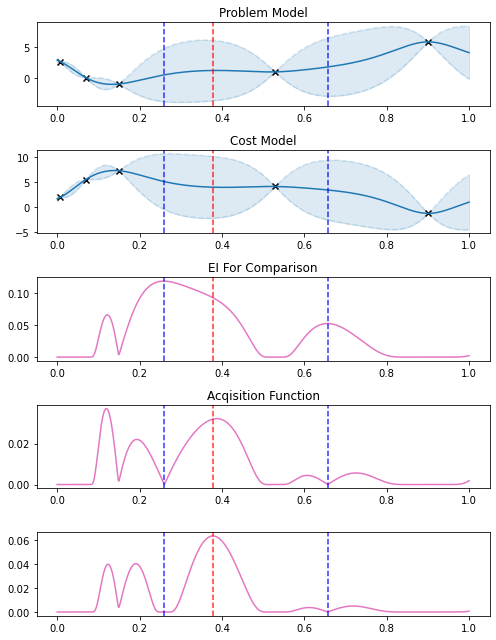

In [9]:
import matplotlib.pyplot as plt
import plotting
import numpy as np
from aegis.batch import ratios, penalisation
from aegis import gp

acq_params = {
    "n_opt_samples": 1 * 1000,
    "n_opt_bfgs": 10,
}

asbo.step()

res = asbo.get_results()
models = asbo.get_models()

T_data = asbo.output_transform(asbo.Ytr)
T_time = asbo.output_transform(asbo.time_taken)

fig, axs = plt.subplots(5, figsize=(7,9))

color = np.array([31, 119, 180])/255
plotting.gp_plot(axs[0], models["ProblemModel"], T_data, color=color)
axs[0].set(title="Problem Model")
if "CostModel" in models:
    plotting.gp_plot(axs[1], models["CostModel"], T_time, color=color)
    axs[1].set(title="Cost Model")

# Get EI for comparison
EI = ratios.EI(
    models["ProblemModel"],
    asbo.f.lb,
    asbo.f.ub,
    under_evaluation=asbo.ue.get(),
    **acq_params,
)
plotting.acq_plot(axs[2], EI)
axs[2].set(title="EI For Comparison")

# Acq function we're using
plotting.acq_plot(axs[3], asbo.acq)
axs[3].set(title="Acqisition Function")

# Forward look at our acq func
def _setup_gp(train_x, train_y):

    # Scale outputs
    T = asbo.output_transform(train_y)
    train_y = T.scale_mean(train_y)

    # Fit gp
    model, likelihood = gp.create_and_fit_GP(
        train_x=train_x,
        train_y=train_y,
        ls_bounds=asbo.ls_bounds,
        out_bounds=asbo.out_bounds,
        n_restarts=10,
        verbose=asbo.verbose
    )

    return model, likelihood
next_to_finish = np.argmin(asbo.interface._running_jobs_timings)
tmp_task = asbo.interface._running_tasks[next_to_finish]
tmp_model, _ = _setup_gp(torch.cat((asbo.Xtr, tmp_task["x"])), torch.cat((asbo.Ytr, tmp_task["f"](tmp_task["x"]))))
tmp_model.eval()
tmp_cost_model, _ = _setup_gp(torch.cat((asbo.Xtr, tmp_task["x"])), torch.cat((asbo.cost, tmp_task["t"])))
tmp_cost_model.eval()
tmp_ue = util.UnderEval(n_workers, asbo.f.dim, asbo.dtype)
_tasks = asbo.interface._running_tasks
for k in range(len(_tasks)):
    if k == next_to_finish:
        continue
    tmp_ue.add(_tasks[k]["x"])
tmp_acq = penalisation.HardLocalPenalisationBatchBOCost(
    model=tmp_model,
    cost_model=tmp_cost_model,
    T_data=asbo.output_transform(asbo.Ytr),
    T_cost=asbo.output_transform(asbo.cost),
    lb=asbo.f.lb,
    ub=asbo.f.ub,
    under_evaluation=tmp_ue.get(),
    **asbo.acq_params,
)
plotting.acq_plot(axs[4], tmp_acq)

# Mark our choice
plotting.mark_acq_choice_plot(axs, tmp_acq, color='red')

# Mark ongoings
for x in asbo.ue.get():
    plotting.plot_vline_axes(axs, x, color="blue")

# Mark EI's choice for comparison
#plotting.mark_acq_choice_plot(axs, EI, color='green')

fig.tight_layout()

In [7]:
print(asbo.interface._running_jobs_timings)
print(asbo.interface._running_tasks)
print(next_to_finish)
print(tmp_task)
print(asbo.ue.get())
print(asbo.ue.get()[next_to_finish])

print(tmp_ue.get())

[1.28802146 7.59221103]
[{'x': tensor([[0.1490]], dtype=torch.float64), 'f': <aegis.util.TorchProblem object at 0x7f522bf32aa0>, 't': tensor([6.6487], dtype=torch.float64)}, {'x': tensor([[0.6631]], dtype=torch.float64), 'f': <aegis.util.TorchProblem object at 0x7f522bf32aa0>, 't': tensor([7.5922], dtype=torch.float64)}]
0
{'x': tensor([[0.1490]], dtype=torch.float64), 'f': <aegis.util.TorchProblem object at 0x7f522bf32aa0>, 't': tensor([6.6487], dtype=torch.float64)}
tensor([[0.6631],
        [0.1490]], dtype=torch.float64)
tensor([0.6631], dtype=torch.float64)
tensor([[0.6631]], dtype=torch.float64)
